In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tabulate import tabulate
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_classif, SelectKBest, SequentialFeatureSelector
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
!mkdir figures

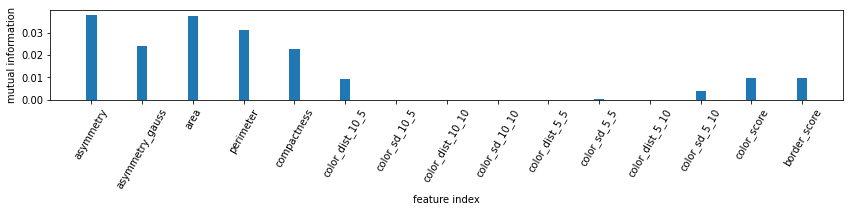

In [ ]:
df = pd.read_csv("features/features_training.csv")
X = df.drop(["image_id", "melanoma"], axis=1)
y = df["melanoma"]
feature_names = list(df)[2:]
selector = SelectKBest(mutual_info_classif, k=2)
selector.fit(X, y)

# Show the feature scores
scores = selector.scores_


fig, ax = plt.subplots(figsize=(12,3))
ax.bar(feature_names, scores, width=.2)
ax.set_xlabel('feature index')
ax.set_ylabel('mutual information')
plt.xticks(rotation=60);
plt.tight_layout()
plt.savefig("figures/mutual_info.png", bbox_inches="tight", dpi=400)

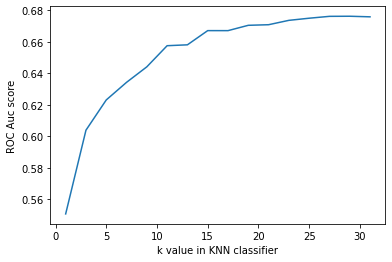

In [ ]:
df = pd.read_csv("features/features_training.csv")
features = ["asymmetry", "area", "perimeter", "color_dist_10_5", "color_score"]

x = df[features].to_numpy()
y = np.array(df["melanoma"])

x = MinMaxScaler().fit_transform(x)

n_splits = 5
kf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.4, random_state=1)

k_auc_scores = np.empty((16))

for j, k in enumerate(range(1, 32, 2)):
    acc_val_knn = np.empty((n_splits, 1))
    auc_val_knn = np.empty((n_splits, 1))
    acc_val_tree = np.empty((n_splits, 1))
    auc_val_tree = np.empty((n_splits, 1))

    threshold = 0.2

    for i, (train_index, val_index) in enumerate(kf.split(x, y)):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        clf = KNeighborsClassifier(n_neighbors=k)
        clf = clf.fit(x_train, y_train)
        y_pred_val = clf.predict(x_val)
        y_prob_val = clf.predict_proba(x_val)[:,1]
        
        acc_val_knn[i] = accuracy_score(y_val, y_pred_val)
        auc_val_knn[i] = roc_auc_score(y_val, y_prob_val)

        clf = DecisionTreeClassifier(random_state=1)
        clf.fit(x_train, y_train)
        y_pred_val = clf.predict(x_val)
        y_prob_val = clf.predict_proba(x_val)[:,1]

        acc_val_tree[i] = accuracy_score(y_val, y_pred_val)
        auc_val_tree[i] = roc_auc_score(y_val, y_prob_val)
        

    k_auc_scores[j] = np.mean(auc_val_knn)
ax = sns.lineplot(x=range(1, 32, 2), y=k_auc_scores)
ax.set_ylabel("ROC Auc score")
ax.set_xlabel("k value in KNN classifier")
# ax.set_title("ROC Auc score at different values of k");
plt.savefig("figures/auc_different_k.png", bbox_inches="tight", dpi=400)

KNN Accuracy scores
acc_score: 0.806 ±0.01
auc_score: 0.644 ±0.01
______________________________
Decision Tree Accuracy scores
acc_score: 0.724 ±0.01
auc_score: 0.547 ±0.01

Confusion matrix for threshold 0.2
[[0.58646154 0.41353846]
 [0.38133333 0.61866667]]


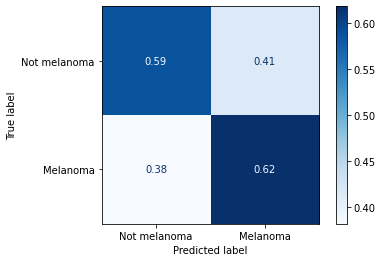

In [ ]:
df = pd.read_csv("features/features_training.csv")
features = ["asymmetry", "area", "perimeter", "color_dist_10_5", "color_score"]

x = df[features].to_numpy()
y = np.array(df["melanoma"])

x = MinMaxScaler().fit_transform(x)

n_splits = 5
kf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.4, random_state=1)

acc_val_knn = np.empty((n_splits, 1))
auc_val_knn = np.empty((n_splits, 1))
acc_val_tree = np.empty((n_splits, 1))
auc_val_tree = np.empty((n_splits, 1))

k = 9
threshold = 0.2


conf_mats = []

for i, (train_index, val_index) in enumerate(kf.split(x, y)):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

    clf = KNeighborsClassifier(n_neighbors=k)
    clf = clf.fit(x_train, y_train)
    y_pred_val = clf.predict(x_val)
    y_prob_val = clf.predict_proba(x_val)[:,1]
    
    acc_val_knn[i] = accuracy_score(y_val, y_pred_val)
    auc_val_knn[i] = roc_auc_score(y_val, y_prob_val)

    conf_mats.append(confusion_matrix(y_val, y_prob_val > threshold))

    clf = DecisionTreeClassifier(random_state=1)
    clf.fit(x_train, y_train)
    y_pred_val = clf.predict(x_val)
    y_prob_val = clf.predict_proba(x_val)[:,1]

    acc_val_tree[i] = accuracy_score(y_val, y_pred_val)
    auc_val_tree[i] = roc_auc_score(y_val, y_prob_val)
    

    

print("KNN Accuracy scores")
print(f"acc_score: {np.mean(acc_val_knn):.3f} ±{np.std(acc_val_knn):.2f}")
print(f"auc_score: {np.mean(auc_val_knn):.3f} ±{np.std(auc_val_knn):.2f}")
print("_"*30)
print("Decision Tree Accuracy scores")
print(f"acc_score: {np.mean(acc_val_tree):.3f} ±{np.std(acc_val_tree):.2f}")
print(f"auc_score: {np.mean(auc_val_tree):.3f} ±{np.std(auc_val_tree):.2f}")

print(f"\nConfusion matrix for threshold {threshold}")
conf_mats = np.stack(conf_mats, axis=2)
avg_conf_mat = np.mean(conf_mats, axis=2)
avg_conf_mat = normalize(avg_conf_mat, norm="l1")
print(avg_conf_mat)
display = ConfusionMatrixDisplay(avg_conf_mat, display_labels=["Not melanoma", "Melanoma"])
display.plot(cmap=plt.cm.Blues);

Selected features for JSON Features:  [ 4  9  6 19  5]
KNN Accuracy scores
acc_score: 0.814 ±0.00
auc_score: 0.645 ±0.02
______________________________
Decision Tree Accuracy scores
acc_score: 0.727 ±0.01
auc_score: 0.568 ±0.01

Confusion matrix for threshold 0.2
[[0.64184615 0.35815385]
 [0.424      0.576     ]]


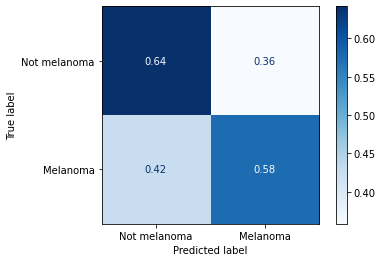

In [ ]:
df = pd.read_csv("features/features_training.csv")
features = ["asymmetry", "area", "perimeter", "color_dist_10_5", "color_score"]

x = df[features].to_numpy()
y = np.array(df["melanoma"])

# JSON Data
def to_numpy(arr):
    return np.array(arr[1:-1].split(), dtype=int)

converters = {'pigment_network_hist': to_numpy, 'negative_network_hist': to_numpy, 'milia_like_hist': to_numpy, 'streaks_hist': to_numpy}
jdf = pd.read_csv("features/json_training.csv", converters=converters)
features = list(jdf.drop(columns=["image_id", "melanoma"]))
xj = np.hstack([np.vstack(jdf[feat].to_numpy()) for feat in features])
selector = SelectKBest(mutual_info_classif, k=5)
selector.fit(xj, y)
scores = selector.scores_
selected_indices = np.argsort(selector.scores_)[-5:]
print("Selected features for JSON Features: ", selected_indices)
xj = xj[:, selected_indices]
x = np.c_[x, xj]


x = MinMaxScaler().fit_transform(x)

n_splits = 5
kf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.4, random_state=1)

acc_val_knn = np.empty((n_splits, 1))
auc_val_knn = np.empty((n_splits, 1))
acc_val_tree = np.empty((n_splits, 1))
auc_val_tree = np.empty((n_splits, 1))

k = 9
threshold = 0.2


conf_mats = []

for i, (train_index, val_index) in enumerate(kf.split(x, y)):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

    clf = KNeighborsClassifier(n_neighbors=k)
    clf = clf.fit(x_train, y_train)
    y_pred_val = clf.predict(x_val)
    y_prob_val = clf.predict_proba(x_val)[:,1]
    
    acc_val_knn[i] = accuracy_score(y_val, y_pred_val)
    auc_val_knn[i] = roc_auc_score(y_val, y_prob_val)

    conf_mats.append(confusion_matrix(y_val, y_prob_val > threshold))

    clf = DecisionTreeClassifier(random_state=1)
    clf.fit(x_train, y_train)
    y_pred_val = clf.predict(x_val)
    y_prob_val = clf.predict_proba(x_val)[:,1]

    acc_val_tree[i] = accuracy_score(y_val, y_pred_val)
    auc_val_tree[i] = roc_auc_score(y_val, y_prob_val)
    

    

print("KNN Accuracy scores")
print(f"acc_score: {np.mean(acc_val_knn):.3f} ±{np.std(acc_val_knn):.2f}")
print(f"auc_score: {np.mean(auc_val_knn):.3f} ±{np.std(auc_val_knn):.2f}")
print("_"*30)
print("Decision Tree Accuracy scores")
print(f"acc_score: {np.mean(acc_val_tree):.3f} ±{np.std(acc_val_tree):.2f}")
print(f"auc_score: {np.mean(auc_val_tree):.3f} ±{np.std(auc_val_tree):.2f}")

print(f"\nConfusion matrix for threshold {threshold}")
conf_mats = np.stack(conf_mats, axis=2)
avg_conf_mat = np.mean(conf_mats, axis=2)
avg_conf_mat = normalize(avg_conf_mat, norm="l1")
print(avg_conf_mat)
display = ConfusionMatrixDisplay(avg_conf_mat, display_labels=["Not melanoma", "Melanoma"])
display.plot(cmap=plt.cm.Blues);

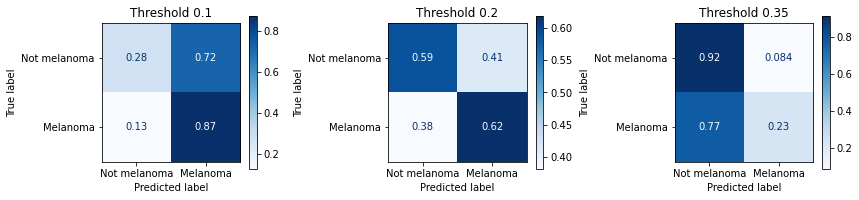

In [ ]:
df = pd.read_csv("features/features_training.csv")
features = ["asymmetry", "area", "perimeter", "color_dist_10_5", "color_score"]

x = df[features].to_numpy()
y = np.array(df["melanoma"])

x = MinMaxScaler().fit_transform(x)

n_splits = 5
kf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.4, random_state=1)

k = 9 

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for threshold, ax in zip([0.1, 0.2, 0.35], axes.flatten()):
    conf_mats = []
    for i, (train_index, val_index) in enumerate(kf.split(x, y)):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        clf = KNeighborsClassifier(n_neighbors=k)
        clf = clf.fit(x_train, y_train)
        y_pred_val = clf.predict(x_val)
        y_prob_val = clf.predict_proba(x_val)[:,1]

        conf_mats.append(confusion_matrix(y_val, y_prob_val > threshold))

    conf_mats = np.stack(conf_mats, axis=2)
    avg_conf_mat = np.mean(conf_mats, axis=2)
    avg_conf_mat = normalize(avg_conf_mat, norm="l1")
    display = ConfusionMatrixDisplay(avg_conf_mat, display_labels=["Not melanoma", "Melanoma"])
    display.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f"Threshold {threshold}")
plt.tight_layout()
plt.savefig("figures/conf_mats.png", bbox_inches="tight", dpi=400)

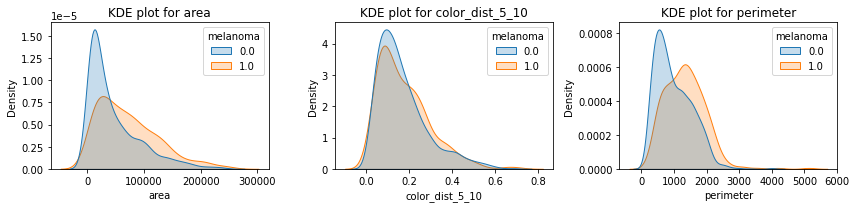

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
features = ['area', 'color_dist_5_10', 'perimeter']
for feature, ax in zip(features, axes.flatten()):
    sns.kdeplot(feature, data=df, hue="melanoma", fill=True, common_norm=False, ax=ax)
    ax.set_title(f"KDE plot for {feature}")
    
plt.tight_layout()
plt.savefig("figures/kde_plots.png", bbox_inches="tight", dpi=400)

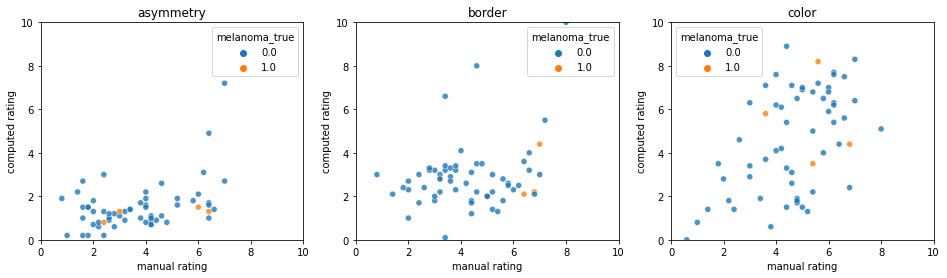

In [ ]:
df = pd.read_csv("classifications/mean_classification.csv")

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

features = ["asymmetry", "border", "color"]
features_class = ["asymmetry_class","border_class", "color_class"]
colors = ["g", "b", "r"]

for i, ax in enumerate(axes.flatten()):
    sns.scatterplot(data=df, x=features[i], y=features_class[i], ax=ax, color = colors[i], 
        hue=df["melanoma_true"], alpha= 0.8)
    ax.set_title(f'{features[i]}')
    ax.set_xlabel("manual rating")
    ax.set_ylabel("computed rating")
    ax.set_xlim([0,10])
    ax.set_ylim([0,10])

plt.savefig("figures/scatter_features.png", bbox_inches="tight", dpi=400)

In [ ]:
y_true = np.array(df["melanoma_true"])
y_pred_manual = np.array(df["melanoma"])
y_pred_class = np.array(df["melanoma_class"])
y_prob_manual = np.array(df["melanoma_prob"])
y_prob_class = np.array(df["melanoma_prob_class"])
print(round(accuracy_score(y_true, y_pred_manual), 2))
print(round(accuracy_score(y_true, y_pred_class), 2))
print(round(accuracy_score(y_pred_manual, y_pred_class), 2))
print()
print(roc_auc_score(y_true, y_prob_manual))
print(roc_auc_score(y_true, y_prob_class))

0.52
0.62
0.33

0.796875
0.3526785714285714


In [ ]:
df = pd.read_csv("data/test_ground_truth.csv")
converter = {"probabilities": lambda x: np.array(x[1:-1].split(), dtype=float)}
class_df = pd.read_csv("classifications/classification_test.csv", converters=converter)
json_df = pd.read_csv("classifications/classification_json_test.csv", converters=converter)
y_true = np.array(df["melanoma"])
y_pred_class = np.array(class_df["label"])
y_pred_json = np.array(json_df["label"])
y_prob_class = np.vstack(class_df["probabilities"])[:, 1]
y_prob_json = np.vstack(json_df["probabilities"])[:, 1]

table = [["Normal classifier"], ["Classifier with JSON features"]]
table[0].append(round(accuracy_score(y_true, y_pred_class), 3))
table[1].append(round(accuracy_score(y_true, y_pred_json), 3))
table[0].append(round(roc_auc_score(y_true, y_prob_class), 3))
table[1].append(round(roc_auc_score(y_true, y_prob_json), 3))
with open("figures/task4_table.tex", "w") as f:
    f.write(tabulate(table, headers=["Classifier", "Accuracy score", "ROC Auc score"], tablefmt="latex_booktabs"))

In [ ]:
def decode_sp_index(rgb_val):
    red = rgb_val[0]
    green = rgb_val[1]
    blue = rgb_val[2]
    return red + (green << 8) + (blue << 16)


def visualize(img_file, sp_file, json_file, feature, ax, rgb=(0,0,0), opacity=30):
    df = pd.read_json(json_file)
    spmask = Image.open(sp_file)
    spmask.thumbnail((600, 600), resample=False)
    spmask = np.array(spmask)
    indices = np.empty((spmask.shape[:2]))
    for x in range(spmask.shape[0]):
        for y in range(spmask.shape[1]):
            indices[x,y] = decode_sp_index(spmask[x,y])
    arr = np.empty_like(indices, dtype=bool)
    for i, val in enumerate(df[feature]):
        arr[np.where(indices == i)] = not val
    mask = np.uint8(np.stack([np.full_like(arr, c, dtype=int) for c in rgb] + [(~arr)*opacity], axis=2))
    mask = Image.fromarray(mask)
    img = Image.open(img_file).convert("RGBA")
    img.paste(mask, mask=mask)
    ax.imshow(np.array(img))
    ax.axis("off")
    ax.set_title(feature)

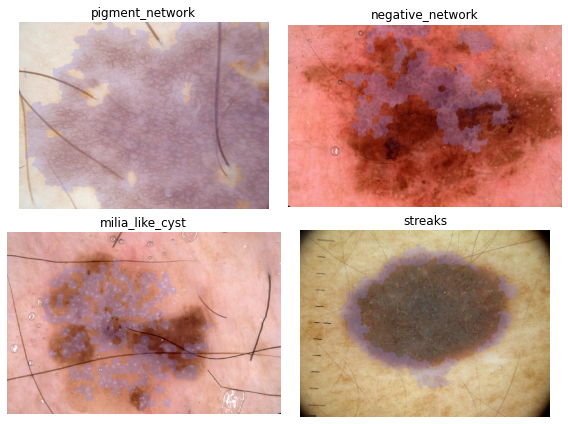

In [ ]:
img_names = ["ISIC_0010588", "ISIC_0014714", "ISIC_0015112", "ISIC_0010233"]
features = ["pigment_network", "negative_network", "milia_like_cyst", "streaks"]
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for img_id, feat, ax in zip(img_names, features, axes.flatten()):
    img_file = f"data/data_for_plots/{img_id}.jpg"
    sp_file = f"data/data_for_plots/{img_id}_superpixels.png"
    json_file = f"data/data_for_plots/{img_id}_features.json"
    visualize(img_file, sp_file, json_file, feat, ax, rgb=(29, 30, 230), opacity=40)
plt.tight_layout()
plt.savefig("figures/json_visualization.png", bbox_inches="tight", dpi=400)

In [ ]:
df = pd.read_csv("features/features_training.csv")
drop_cols = ["image_id", "melanoma", "color_sd_10_10", "color_dist_10_5", "color_sd_10_5", "color_dist_5_5", "color_sd_5_5", "color_dist_5_10", "color_sd_5_10"]
x_train = df.drop(drop_cols, axis=1).to_numpy()
feature_names = list(df)
for col in drop_cols:
    feature_names.remove(col)
feature_names = np.array(feature_names)
y = np.array(df["melanoma"])
clf = KNeighborsClassifier(n_neighbors=5)
kf = StratifiedShuffleSplit(n_splits=5, test_size=0.4, random_state=1)
n_features = 6

selector = SequentialFeatureSelector(clf, n_features_to_select=n_features, direction="forward", cv=kf)
sfs_forward = selector.fit(x_train, y)
print("Forward selected features")
print(feature_names[sfs_forward.get_support()])
print()

selector = SequentialFeatureSelector(clf, n_features_to_select=n_features, direction="backward", cv=kf)
sfs_backward = selector.fit(x_train, y)
print("Backwards selected features")
print(feature_names[sfs_backward.get_support()])
print()

features_fb = [feature_names[sfs.get_support()] for sfs in [sfs_forward, sfs_backward]]

for j, features in enumerate(features_fb):
    x = df[features].to_numpy()
    x = MinMaxScaler().fit_transform(x)
    acc_val_knn = np.empty((n_splits, 1))
    auc_val_knn = np.empty((n_splits, 1))
    acc_val_tree = np.empty((n_splits, 1))
    auc_val_tree = np.empty((n_splits, 1))

    k = 5
    for i, (train_index, val_index) in enumerate(kf.split(x, y)):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        clf = KNeighborsClassifier(n_neighbors=k)
        clf = clf.fit(x_train, y_train)
        y_pred_val = clf.predict(x_val)
        y_prob_val = clf.predict_proba(x_val)[:,1]
        
        acc_val_knn[i] = accuracy_score(y_val, y_pred_val)
        auc_val_knn[i] = roc_auc_score(y_val, y_prob_val)

        clf = DecisionTreeClassifier(random_state=1)
        clf.fit(x_train, y_train)
        y_pred_val = clf.predict(x_val)
        y_prob_val = clf.predict_proba(x_val)[:,1]

        acc_val_tree[i] = accuracy_score(y_val, y_pred_val)
        auc_val_tree[i] = roc_auc_score(y_val, y_prob_val)
        
    print("KNN Accuracy scores")
    print(f"acc_score: {np.mean(acc_val_knn):.3f} ±{np.std(acc_val_knn):.2f}")
    print(f"auc_score: {np.mean(auc_val_knn):.3f} ±{np.std(auc_val_knn):.2f}")
    print("_"*30)
    print("Decision Tree Accuracy scores")
    print(f"acc_score: {np.mean(acc_val_knn):.3f} ±{np.std(acc_val_tree):.2f}")
    print(f"auc_score: {np.mean(auc_val_knn):.3f} ±{np.std(auc_val_tree):.2f}")
    print()

Forward selected features
['asymmetry' 'asymmetry_gauss' 'perimeter' 'compactness'
 'color_dist_10_10' 'color_score']

Backwards selected features
['area' 'perimeter' 'compactness' 'color_dist_10_10' 'color_score'
 'border_score']

KNN Accuracy scores
acc_score: 0.787 ±0.01
auc_score: 0.607 ±0.02
______________________________
Decision Tree Accuracy scores
acc_score: 0.787 ±0.01
auc_score: 0.607 ±0.02

KNN Accuracy scores
acc_score: 0.787 ±0.01
auc_score: 0.583 ±0.02
______________________________
Decision Tree Accuracy scores
acc_score: 0.787 ±0.02
auc_score: 0.583 ±0.01



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6840a14b-d41a-45b9-abd0-892354334cb2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>